In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from packet_utils import generate_access_code_ble, create_ble_phy_packet, unpack_uint8_to_bits
from filters import gaussian_fir_taps
from demodulation import frequency_demodulate
from modulation import modulate_bits_fir, frequency_modulate
from receiver import ReceiverBLE

# payload -> packet (bytes)(whitened) DONE
# bytes -> bits DONE
# bits -> IQ DONE
# Encapsulate the process in a class

# Payload -> packet (bytes, whitened)

In [2]:
# Example values:
base_address = 0x12345678
payload = np.array([0xAB, 0xCD], dtype=np.uint8)

packet = create_ble_phy_packet(payload, base_address)
print("Packet bytes:")
print([hex(byte) for byte in packet])

Packet bytes:
['0xaa', '0x78', '0x56', '0x34', '0x12', '0x0', '0x40', '0xb0', '0x17', '0xe', '0x70', '0x36', '0x9d']


# Packet bytes -> bits

In [3]:
unpacked = unpack_uint8_to_bits(packet)
print("Unpacked bits:", unpacked)

# For comparison (I'm sure this function works)
print(generate_access_code_ble(base_address=base_address))

Unpacked bits: [0 1 0 1 0 1 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 1
 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 0 0 1]
01010101_00011110_01101010_00101100_01001000_00000000


# GFSK modulation (bits -> symbols)

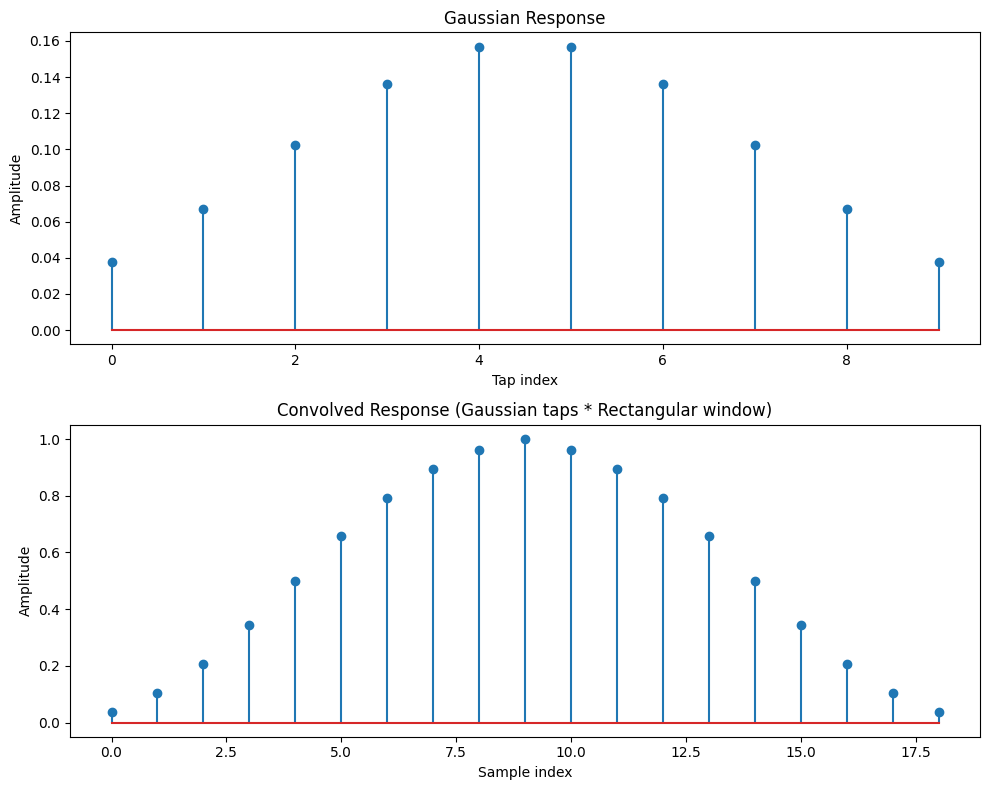

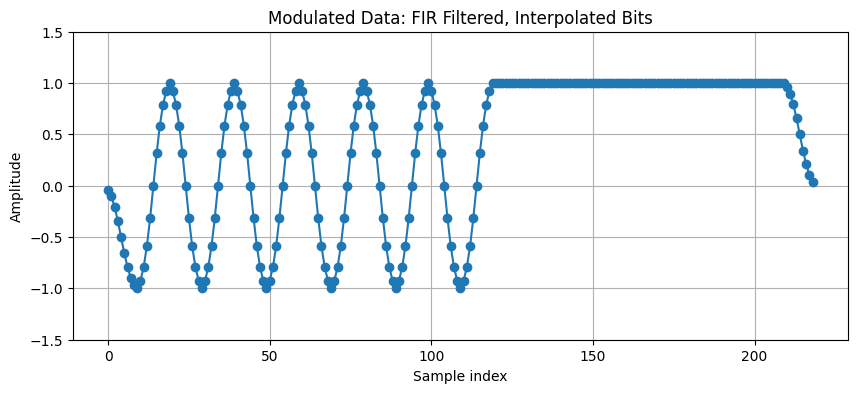

In [4]:
sps = 10  # Samples per symbol
bt = 0.5  # Bandwidth-bit period product (BLE PHY specification)

# Generate Gaussian taps and convolve with rectangular window
gauss_response = gaussian_fir_taps(sps=sps, ntaps=sps, bt=bt)
convolved_response = scipy.signal.convolve(gauss_response, np.ones(sps))

# Create a test bit sequence
bits = np.array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Use the modulate_bits function to get the filtered (modulated) data.
# modulated_data = modulate_bits_fir(bits, sps, gauss_response)
modulated_data = modulate_bits_fir(bits, fir_taps=convolved_response, sps=sps)


# Plot the results
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# 1. Plot Gaussian taps
axs[0].stem(gauss_response)
axs[0].set_title("Gaussian Response")
axs[0].set_xlabel("Tap index")
axs[0].set_ylabel("Amplitude")

# 2. Plot the convolved response
axs[1].stem(convolved_response)
axs[1].set_title("Convolved Response (Gaussian taps * Rectangular window)")
axs[1].set_xlabel("Sample index")
axs[1].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


# Plot the modulated data
plt.figure(figsize=(10, 4))
plt.plot(modulated_data, marker="o", linestyle="-")
plt.title("Modulated Data: FIR Filtered, Interpolated Bits")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.ylim((-1.5, 1.5))
plt.grid(True)
plt.show()

# Try with half-sine shapes

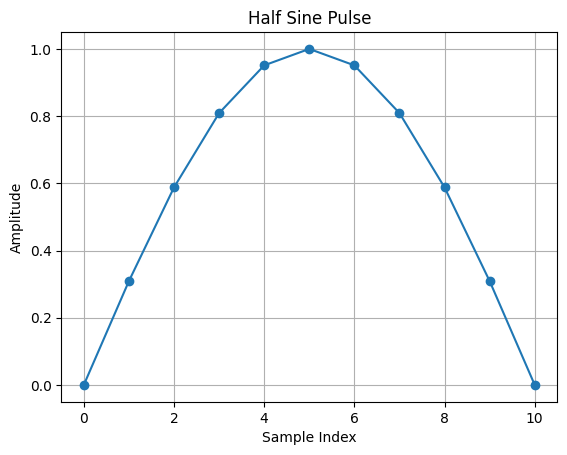

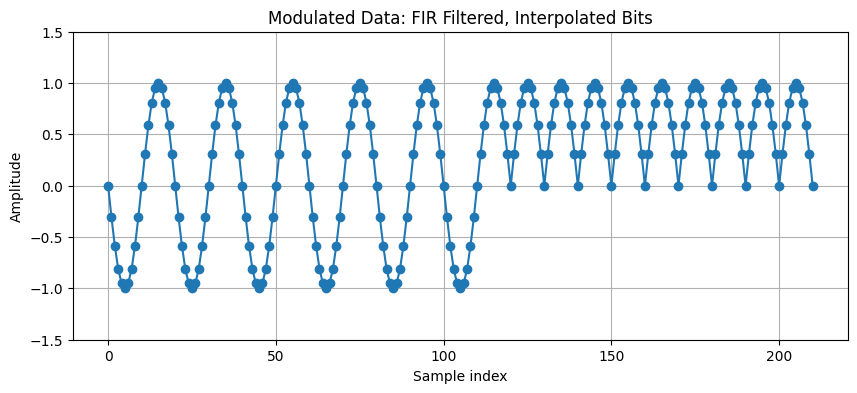

In [5]:
# Generate the half-sine pulse
half_sine_pulse = np.sin(np.linspace(0, np.pi, sps + 1))

# Plot the pulse
plt.figure()
plt.plot(half_sine_pulse, marker="o")
plt.title("Half Sine Pulse")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

hss_modulated_data = modulate_bits_fir(bits, fir_taps=half_sine_pulse, sps=sps)

# -------------------------
# Plot the modulated data
plt.figure(figsize=(10, 4))
plt.plot(hss_modulated_data, marker="o", linestyle="-")
plt.title("Modulated Data: FIR Filtered, Interpolated Bits")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.ylim((-1.5, 1.5))
plt.grid(True)
plt.show()

# FM modulation (symbols -> IQ)

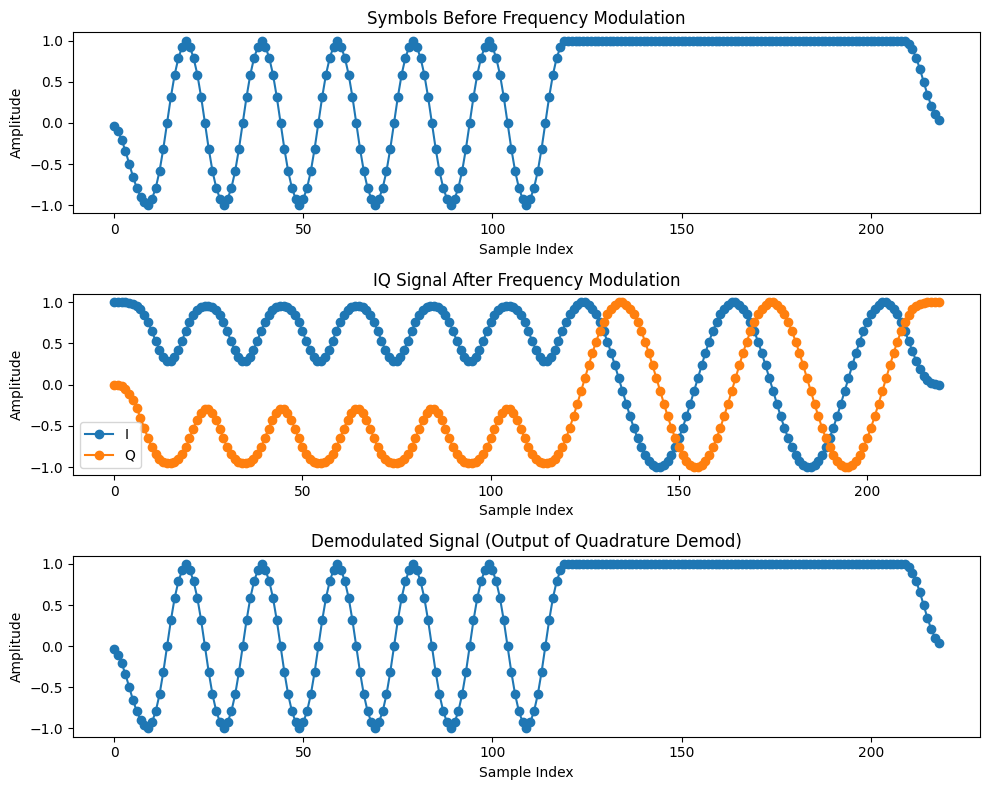

In [6]:
fsk_deviation = 250e3  # Hz
ble_transmission_rate = 1e6  # Hz
fs = ble_transmission_rate * sps

frequency_modulated = frequency_modulate(modulated_data, fsk_deviation, fs)

# Output of this should be equal to modulated_data (symbols)
comparison_fm_demod = frequency_demodulate(frequency_modulated, gain=(fs) / (2 * np.pi * fsk_deviation))


def plot_fsk_signals(symbols: np.ndarray, iq_signal: np.ndarray, demod_signal: np.ndarray):
    fig, axs = plt.subplots(3, 1, figsize=(10, 8))

    # Plot 1: Symbols (real signal before modulation)
    axs[0].plot(symbols, marker="o")
    axs[0].set_title("Symbols Before Frequency Modulation")
    axs[0].set_ylabel("Amplitude")
    axs[0].set_xlabel("Sample Index")

    # Plot 2: IQ signal (after frequency modulation)
    axs[1].plot(np.real(iq_signal), label="I", marker="o")
    axs[1].plot(np.imag(iq_signal), label="Q", marker="o")
    axs[1].set_title("IQ Signal After Frequency Modulation")
    axs[1].set_ylabel("Amplitude")
    axs[1].set_xlabel("Sample Index")
    axs[1].legend()

    # Plot 3: Demodulated signal (real)
    axs[2].plot(demod_signal, marker="o")
    axs[2].set_title("Demodulated Signal (Output of Quadrature Demod)")
    axs[2].set_ylabel("Amplitude")
    axs[2].set_xlabel("Sample Index")

    plt.tight_layout()
    plt.show()


plot_fsk_signals(modulated_data, frequency_modulated, comparison_fm_demod)

# Encapsulate BLE modulation (from payload to IQ)